In [2]:
pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 3.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import wave,os,librosa,tqdm,time,shutil
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa, os, cv2, pickle, tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,Input
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE

In [4]:
feats = pd.read_csv('/kaggle/input/IEMOCAP_OpenSMILE_Features_2.csv')

In [5]:
feats = feats[feats.label.isin(['neutral','happy','angry','sad'])]
feats.label.value_counts()

label
neutral    1708
happy      1636
angry      1103
sad        1084
Name: count, dtype: int64

In [6]:
def split_preprocess(df,apply_smote=False,rs=536,returnscalerle=False):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  le = LabelEncoder()
  trainY_enc = to_categorical(le.fit_transform(trainY))
  testY_enc = to_categorical(le.transform(testY))
  if returnscalerle:
    return trainX, testX, trainY, testY, trainY_enc,testY_enc, scaler,le
  return trainX, testX, trainY, testY,trainY_enc,testY_enc

In [7]:
trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=86,returnscalerle=True)
model = Sequential()
model.add(Input((trainX.shape[1],)))
model.add(Dense(20, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │       127,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,484 (517.52 KB)

 Trainable params: 132,204 (516.42 KB)

 Non-trainable params: 280 (1.09 KB)

In [8]:
mpath = '/kaggle/working/ann_model_iemocap_opensmile.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
history = model.fit(trainX, trainY_enc, epochs=500, batch_size=64, validation_data=(testX, testY_enc),callbacks=callbacks)
_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))
predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
print(classification_report(testY, predicted_labels))
new_mpath = f"/kaggle/working/ann_model_iemocap_opensmile_val_acc_{accuracy*100:.2f}.keras"
shutil.move(mpath, new_mpath)

Epoch 1/500


I0000 00:00:1729872336.473622     105 service.cc:145] XLA service 0x55c8c4062740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729872336.473690     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729872336.473694     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


59/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3642 - loss: 2.6919

I0000 00:00:1729872342.522380     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3744 - loss: 2.6669
Epoch 1: val_accuracy improved from -inf to 0.50407, saving model to /kaggle/working/ann_model_iemocap_opensmile.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.3752 - loss: 2.6649 - val_accuracy: 0.5041 - val_loss: 2.2476 - learning_rate: 0.0010
Epoch 2/500
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5095 - loss: 2.2430
Epoch 2: val_accuracy improved from 0.50407 to 0.60163, saving model to /kaggle/working/ann_model_iemocap_opensmile.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5096 - loss: 2.2413 - val_accuracy: 0.6016 - val_loss: 1.9892 - learning_rate: 0.0010
Epoch 3/500
65/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5227 - loss: 2.0199
Epoch 3: val_accuracy improved from 0.60163 to 0.60434, saving model to /kaggle/working/ann_model_iemocap_opensmile.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5243 - loss: 2.0151 - val_accuracy: 0.6043 - val_loss: 1.837

'/kaggle/working/ann_model_iemocap_opensmile_val_acc_67.57.keras'

In [9]:
pip install keras_tuner

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [20]:
from tensorflow.keras.regularizers import l1,l2,l1_l2
def getRandomHPPMS():
    params = {}
    #params['rs_split'] = np.random.randint(0,1000)
    params['rs_split'] = 86
    params['num_HL'] = np.random.randint(2,4+1)
    for i in range(1,params['num_HL']+1):
        params[f'units_{i}'] = np.random.choice(range(256,512+2,2))
        params[f'KR_{i}'] = np.random.choice(['l1','l2','l1l2','none'])
        params[f'BN_{i}'] = np.random.choice([True,False])
        #params[f'dropout_rate_{i}'] = np.random.choice(np.round(np.arange(0,0.5+0.1,0.1),1))
        params[f'dropout_rate_{i}'] = np.round(np.random.uniform(0,0.5),4)
    params['learning_rate'] = np.random.uniform(0.0001,0.005)
    optims = ['Adam','SGD','RMSprop','Adadelta','Adagrad','Adamax','Nadam']
    params['optimizer'] = np.random.choice(optims)
    params['batch_size'] = np.random.choice(range(32,132,4))
    params['adpLR'] = np.random.choice([True,False])
    params['apply_smote'] = np.random.choice([True,False])
    return params

def buildntrainmodel(params,feats,max_epochs=500):
    trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=params['rs_split'],apply_smote=params['apply_smote'],returnscalerle=True)
    model = Sequential()
    model.add(Input((trainX.shape[1],)))
    for i in range(1,params['num_HL']+1):
        kern = {'l1':l1(),'l2':l2(),'l1l2':l1_l2(),'none':None}
        model.add(Dense(units=params[f'units_{i}'],activation='relu',kernel_regularizer=kern[params[f'KR_{i}']]))
        if params[f'BN_{i}']:
            model.add(BatchNormalization())
        if params[f'dropout_rate_{i}']>0:
            model.add(Dropout(params[f'dropout_rate_{i}']))
    model.add(Dense(len(np.unique(trainY)), activation='softmax'))
    optimizer_dict = {'Adam': Adam(learning_rate=params['learning_rate']),
                      'SGD': SGD(learning_rate=params['learning_rate']),
                      'RMSprop': RMSprop(learning_rate=params['learning_rate']),
                      'Adadelta': Adadelta(learning_rate=params['learning_rate']),
                      'Adagrad': Adagrad(learning_rate=params['learning_rate']),
                      'Adamax': Adamax(learning_rate=params['learning_rate']),
                      'Nadam': Nadam(learning_rate=params['learning_rate'])}
    
    model.compile(optimizer=optimizer_dict[params['optimizer']], loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)]
    if params['adpLR']:
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001))
    histann = model.fit(trainX, trainY_enc, epochs=max_epochs, batch_size=params['batch_size'],validation_data=(testX, testY_enc),callbacks=callbacks)
    _, accuracy = model.evaluate(testX, testY_enc)
    splits = (trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le)
    return accuracy,params,model,splits,histann

In [11]:
import IPython.display as ipd
def plot_history(hist,acc,id):
  plt.figure(figsize=(12, 6))
  plt.suptitle(f'Training & Validation Curves for Best ANN Model - Val_Acc={acc*100:.2f}% at Trial #{id}', fontsize=16)
  plt.subplot(1, 2, 1)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')

  plt.subplot(1, 2, 2)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.tight_layout()
  plt.show()

def tune_hyperparams(ntrials,feats,max_epochs=500):
    max_acc = 0
    totm = 0
    phist = dict()
    histories = dict()
    for i in range(1,ntrials+1):
        st = time.time()
        print(f"\nRunning Trial #{i}\n")
        params = getRandomHPPMS()
        if i==1:
            best_params = params
        print(f"{'Current Value':<15}{'|Best Value So Far':<21}{'|Hyperparameter'}")
        print(f"{'-' * 15}|{'-' * 20}|{'-' * 15}")
        for param, value in params.items():
            best_value = best_params.get(param, 'N/A')
            if param=='learning_rate':
                best_value,value = round(best_value,3),round(value,3)
            print(f"{str(value):<15}|{str(best_value):<20}|{param}")
        print()
        acc,params,model,splits,histann = buildntrainmodel(params,feats,max_epochs=max_epochs)
        trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = splits
        fparams = frozenset(params.items())
        phist[fparams] = acc
        histories[i] = histann
        if acc>max_acc:
            max_acc = acc
            best_params = params
            best_trial = i
            best_model = model
        ipd.clear_output(wait=True)
        en = time.time()
        tm = en-st
        totm+=tm
        ep = len(histann.history['accuracy'])
        tracc = max(histann.history['accuracy'])
        print(f"Trial {i} Complete [{int(tm/3600)}h {int(tm/60)}m {int(tm%60)}s] - Trained for {ep} epochs")
        print(f"train_accuracy = {tracc*100:.3f}%")
        print(f"val_accuracy = {acc*100:.3f}%")
        print(f"Overfitting Difference = {(tracc-acc)*100:.3f}%\n")
        print(f"Best val_accuracy So Far: {max_acc*100:.3f}% at Trial #{best_trial}")
        print(f"Total time elapsed: [{int(totm/3600)}h {int(totm/60)}m {int(totm%60)}s]")
    print(f"Best Hyperparameters: {best_params}")
    print("Best Model Summary:")
    print(best_model.summary())
    best_hist = histories[best_trial]
    plot_history(best_hist,max_acc,best_trial)
    trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=best_params['rs_split'],apply_smote=best_params['apply_smote'],returnscalerle=True)
    predictions = best_model.predict(testX)
    predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
    cm = confusion_matrix(testY, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Best ANN Model")
    plt.show()
    print(f"\nAccuracy = {accuracy_score(testY,predicted_labels)*100:.3f}%\n")
    print(classification_report(testY, predicted_labels))
    best_model.save(f'/kaggle/working/ann_model_iemocap_opensmile_val_acc_{max_acc*100:.3f}.keras')
    return max_acc, best_params, best_trial, best_model, phist,histories

Trial 20 Complete [0h 0m 35s] - Trained for 30 epochs
train_accuracy = 56.845%
val_accuracy = 59.801%
Overfitting Difference = -2.956%

Best val_accuracy So Far: 69.015% at Trial #6
Total time elapsed: [0h 18m 19s]
Best Hyperparameters: {'rs_split': 86, 'num_HL': 2, 'units_1': 334, 'KR_1': 'l1l2', 'BN_1': False, 'dropout_rate_1': 0.1045, 'units_2': 400, 'KR_2': 'l1l2', 'BN_2': False, 'dropout_rate_2': 0.428, 'learning_rate': 0.001507402236158576, 'optimizer': 'Adam', 'batch_size': 96, 'adpLR': False, 'apply_smote': False}
Best Model Summary:


Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_683 (Dense)               │ (None, 334)            │     2,128,916 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_515 (Dropout)           │ (None, 334)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_684 (Dense)               │ (None, 400)            │       134,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_516 (Dropout)           │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_685 (Dense)               │ (None, 4)              │         1,604 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,793,562 (25.92 MB)

 Trainable params: 2,264,520 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,529,042 (17.28 MB)

None


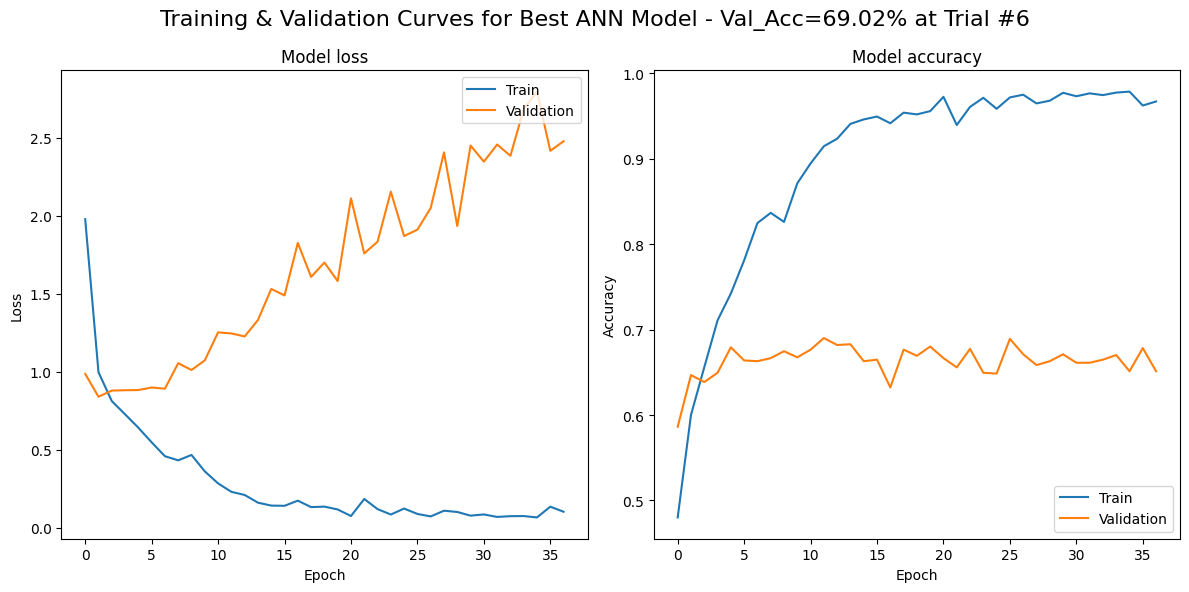

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


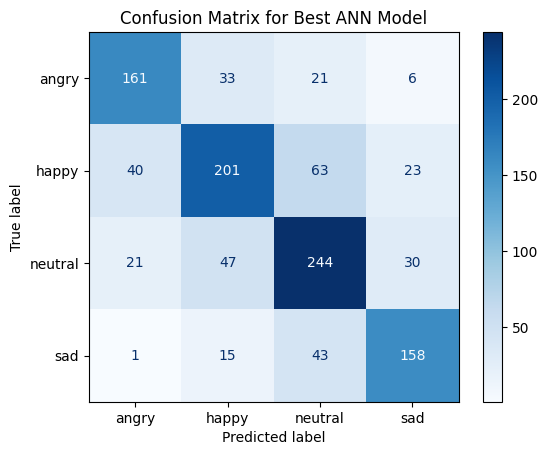


Accuracy = 69.015%

              precision    recall  f1-score   support

       angry       0.72      0.73      0.73       221
       happy       0.68      0.61      0.65       327
     neutral       0.66      0.71      0.68       342
         sad       0.73      0.73      0.73       217

    accuracy                           0.69      1107
   macro avg       0.70      0.70      0.70      1107
weighted avg       0.69      0.69      0.69      1107



In [46]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=feats,max_epochs=500)

Trial 20 Complete [0h 1m 13s] - Trained for 226 epochs
train_accuracy = 51.447%
val_accuracy = 60.976%
Overfitting Difference = -9.529%

Best val_accuracy So Far: 70.370% at Trial #6
Total time elapsed: [0h 14m 12s]
Best Hyperparameters: {'rs_split': 86, 'num_HL': 3, 'units_1': 238, 'KR_1': 'l1l2', 'BN_1': False, 'dropout_rate_1': 0.267, 'units_2': 162, 'KR_2': 'l1l2', 'BN_2': False, 'dropout_rate_2': 0.2149, 'units_3': 132, 'KR_3': 'l1l2', 'BN_3': True, 'dropout_rate_3': 0.0029, 'learning_rate': 0.002457961991356255, 'optimizer': 'Nadam', 'batch_size': 68, 'adpLR': True, 'apply_smote': False}
Best Model Summary:


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_177 (Dense)               │ (None, 238)            │     1,517,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 238)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 162)            │        38,718 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 132)            │        21,516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 132)            │           528 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 4)              │           532 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,734,393 (18.06 MB)

 Trainable params: 1,578,042 (6.02 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 3,156,087 (12.04 MB)

None


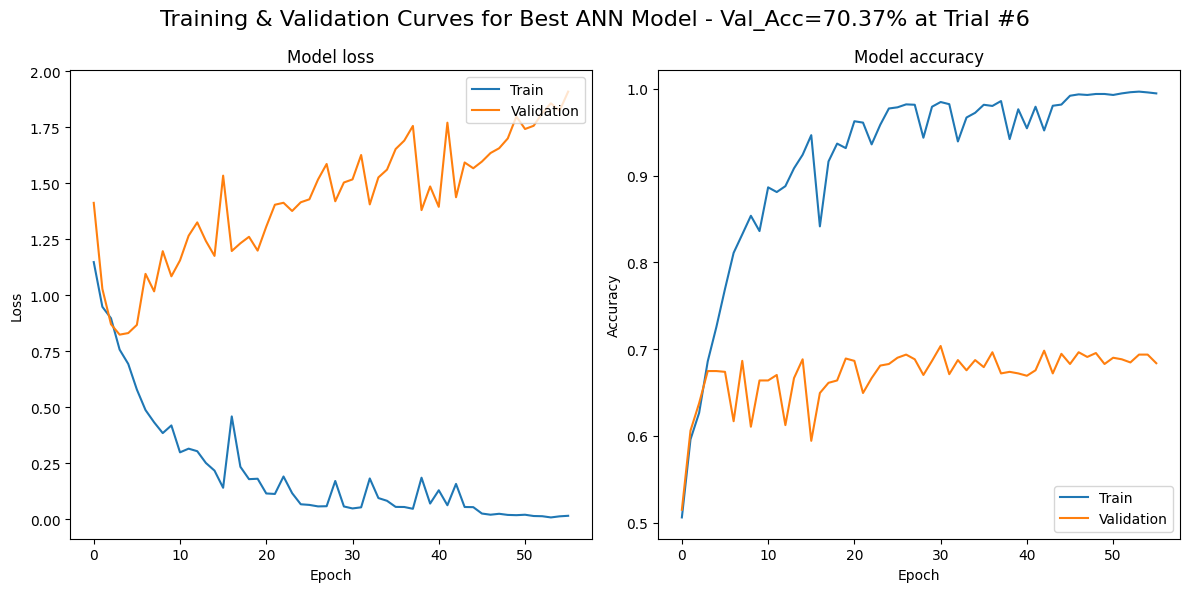

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


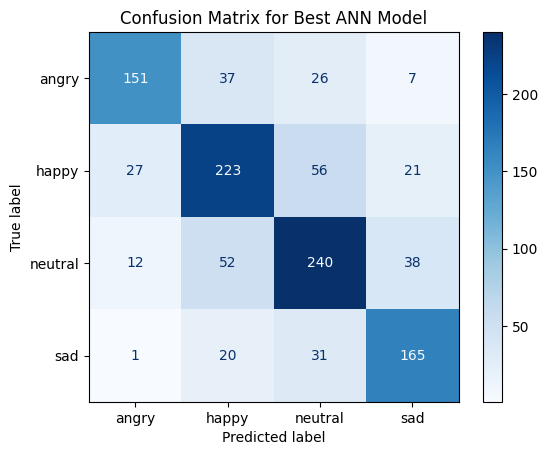


Accuracy = 70.370%

              precision    recall  f1-score   support

       angry       0.79      0.68      0.73       221
       happy       0.67      0.68      0.68       327
     neutral       0.68      0.70      0.69       342
         sad       0.71      0.76      0.74       217

    accuracy                           0.70      1107
   macro avg       0.71      0.71      0.71      1107
weighted avg       0.71      0.70      0.70      1107



In [15]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=feats,max_epochs=500)

Trial 20 Complete [0h 0m 47s] - Trained for 99 epochs
train_accuracy = 99.910%
val_accuracy = 69.106%
Overfitting Difference = 30.804%

Best val_accuracy So Far: 69.648% at Trial #13
Total time elapsed: [0h 15m 19s]
Best Hyperparameters: {'rs_split': 86, 'num_HL': 2, 'units_1': 330, 'KR_1': 'l1l2', 'BN_1': False, 'dropout_rate_1': 0.3755, 'units_2': 418, 'KR_2': 'l2', 'BN_2': False, 'dropout_rate_2': 0.0697, 'learning_rate': 0.001640406087151416, 'optimizer': 'Adagrad', 'batch_size': 48, 'adpLR': False, 'apply_smote': True}
Best Model Summary:


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_372 (Dense)               │ (None, 330)            │     2,103,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_279 (Dropout)           │ (None, 330)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 418)            │       138,358 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_280 (Dropout)           │ (None, 418)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 4)              │         1,676 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,486,910 (17.12 MB)

 Trainable params: 2,243,454 (8.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,243,456 (8.56 MB)

None


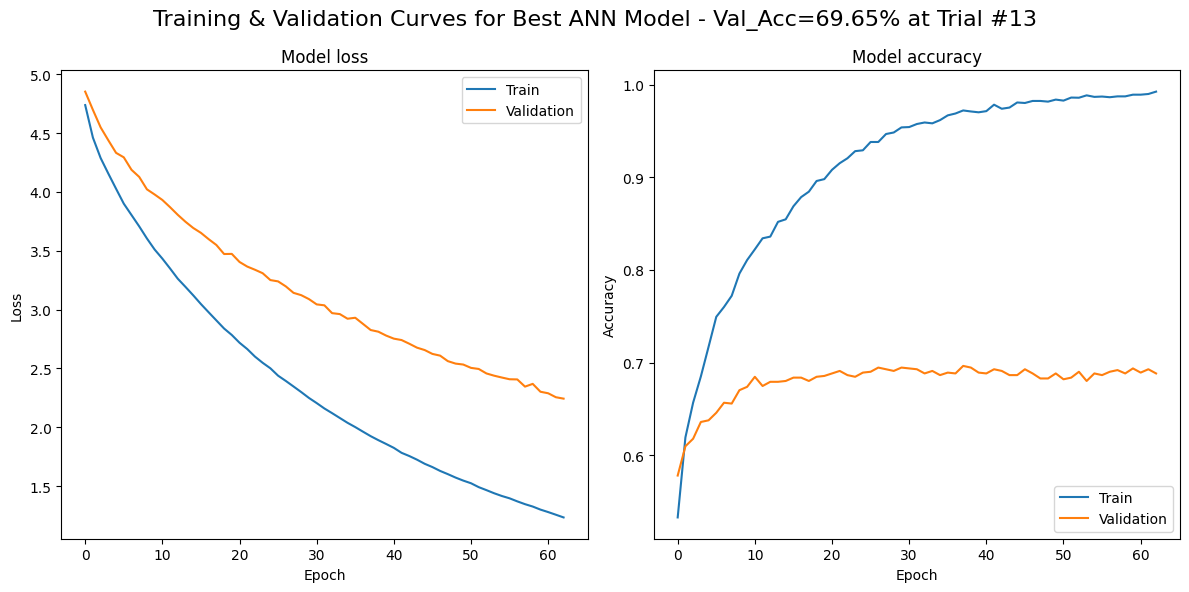

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


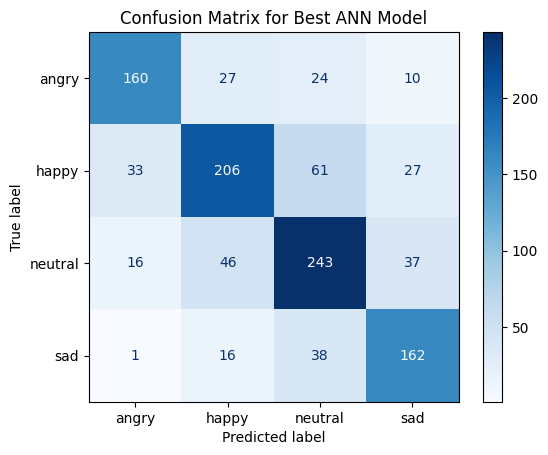


Accuracy = 69.648%

              precision    recall  f1-score   support

       angry       0.76      0.72      0.74       221
       happy       0.70      0.63      0.66       327
     neutral       0.66      0.71      0.69       342
         sad       0.69      0.75      0.72       217

    accuracy                           0.70      1107
   macro avg       0.70      0.70      0.70      1107
weighted avg       0.70      0.70      0.70      1107



In [19]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=feats,max_epochs=500)

Trial 40 Complete [0h 0m 59s] - Trained for 106 epochs
train_accuracy = 96.706%
val_accuracy = 67.751%
Overfitting Difference = 28.955%

Best val_accuracy So Far: 69.738% at Trial #19
Total time elapsed: [0h 33m 37s]
Best Hyperparameters: {'rs_split': 86, 'num_HL': 4, 'units_1': 302, 'KR_1': 'l2', 'BN_1': True, 'dropout_rate_1': 0.4627, 'units_2': 448, 'KR_2': 'l2', 'BN_2': False, 'dropout_rate_2': 0.1165, 'units_3': 310, 'KR_3': 'none', 'BN_3': False, 'dropout_rate_3': 0.1531, 'units_4': 302, 'KR_4': 'none', 'BN_4': False, 'dropout_rate_4': 0.2154, 'learning_rate': 0.0010134227662201413, 'optimizer': 'Adamax', 'batch_size': 88, 'adpLR': True, 'apply_smote': True}
Best Model Summary:


Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_568 (Dense)               │ (None, 302)            │     1,924,948 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_224         │ (None, 302)            │         1,208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_427 (Dropout)           │ (None, 302)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_569 (Dense)               │ (None, 448)            │       135,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_428 (Dropout)           │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_570 (Dense)               │ (None, 310)            │       139,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_429 (Dropout)           │ (None, 310)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_571 (Dense)               │ (None, 302)            │        93,922 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_430 (Dropout)           │ (None, 302)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_572 (Dense)               │ (None, 4)              │         1,212 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,887,466 (26.27 MB)

 Trainable params: 2,295,620 (8.76 MB)

 Non-trainable params: 604 (2.36 KB)

 Optimizer params: 4,591,242 (17.51 MB)

None


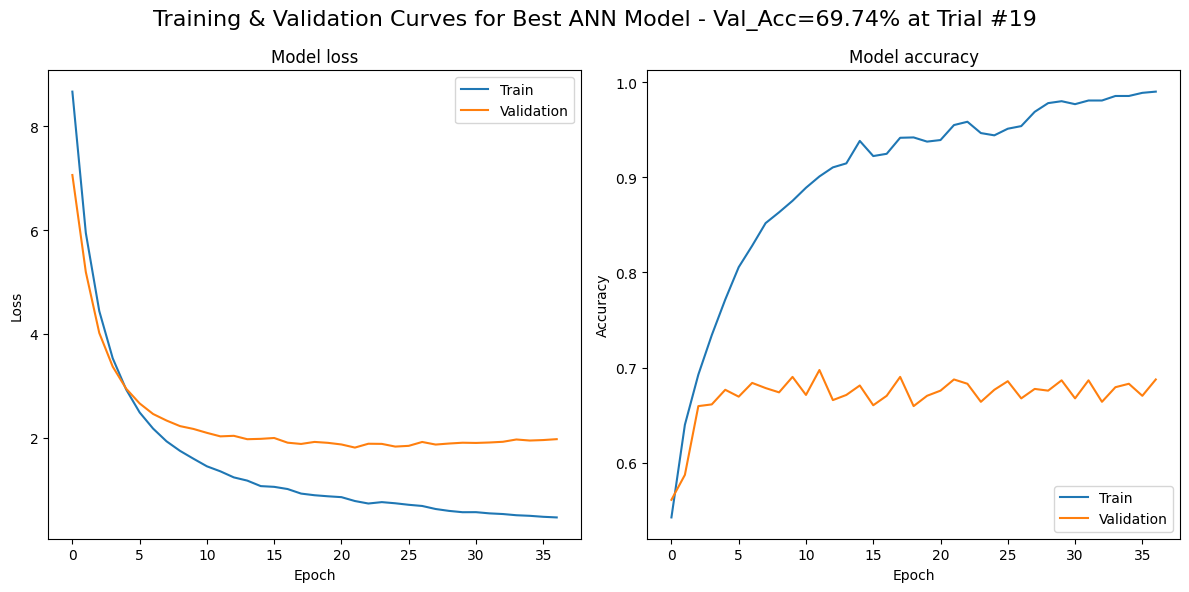

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


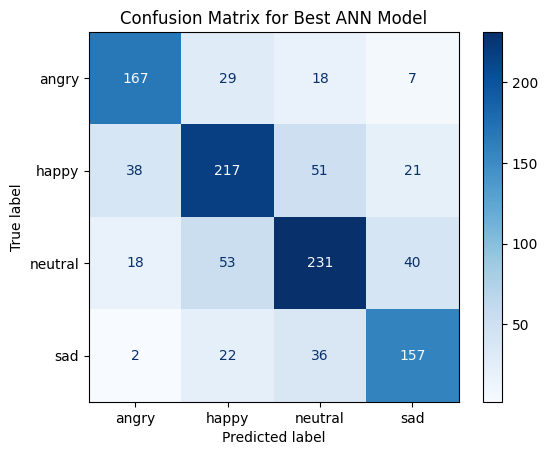


Accuracy = 69.738%

              precision    recall  f1-score   support

       angry       0.74      0.76      0.75       221
       happy       0.68      0.66      0.67       327
     neutral       0.69      0.68      0.68       342
         sad       0.70      0.72      0.71       217

    accuracy                           0.70      1107
   macro avg       0.70      0.70      0.70      1107
weighted avg       0.70      0.70      0.70      1107



In [25]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=40,feats=feats,max_epochs=500)

In [27]:
data = []
for params, acc in phist.items():
    hppms = dict(params)
    hppms['accuracy'] = acc
    data.append(hppms)
df = pd.DataFrame(data)
df = df.reindex(sorted(df.columns), axis=1)
df = df[[col for col in sorted(df.columns) if col != 'accuracy'] + ['accuracy']]
df.sort_values('accuracy',ascending=False,inplace=True,ignore_index=True)
df.head()

,BN_1,BN_2,BN_3,BN_4,KR_1,KR_2,KR_3,KR_4,adpLR,apply_smote,...,dropout_rate_4,learning_rate,num_HL,optimizer,rs_split,units_1,units_2,units_3,units_4,accuracy
0,True,False,False,False,l2,l2,none,none,True,True,...,0.2154,0.001013,4,Adamax,86,302,448,310.0,302.0,0.697380
1,False,True,False,False,l1l2,l1l2,none,l1l2,False,True,...,0.0338,0.004252,4,RMSprop,86,468,468,422.0,422.0,0.696477
2,True,False,False,NaN,l1l2,l1l2,l2,NaN,True,False,...,NaN,0.002092,3,Adam,86,470,492,386.0,NaN,0.695574
3,True,False,False,False,l1l2,none,l2,l1l2,False,True,...,0.3473,0.001476,4,Adamax,86,362,510,284.0,338.0,0.694670
4,True,True,False,False,none,l2,l2,l1,False,True,...,0.2064,0.001464,4,Adamax,86,462,508,374.0,388.0,0.690154


In [29]:
numerical_features = df.iloc[:,:-1].select_dtypes(include=['int64', 'float64'])
categorical_features = df.select_dtypes(include=['object', 'category'])
correlation_matrix = numerical_features.corrwith(df['accuracy'], method='pearson')
print(correlation_matrix.sort_values(ascending=False))

units_4           0.337066
units_2           0.304083
dropout_rate_2    0.071560
dropout_rate_1    0.036300
num_HL            0.011074
dropout_rate_4   -0.015827
batch_size       -0.049915
units_1          -0.165899
learning_rate    -0.229843
units_3          -0.262115
dropout_rate_3   -0.315970
rs_split               NaN
dtype: float64


/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for col in categorical_features:
    model = ols(f'accuracy ~ C({col})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA result for {col}:\n", anova_table)

ANOVA result for BN_3:
             sum_sq    df         F    PR(>F)
C(BN_3)   0.001499   1.0  0.861436  0.360077
Residual  0.057411  33.0       NaN       NaN
ANOVA result for BN_4:
             sum_sq    df         F    PR(>F)
C(BN_4)   0.000118   1.0  0.081483  0.779202
Residual  0.021745  15.0       NaN       NaN
ANOVA result for KR_1:
             sum_sq    df         F    PR(>F)
C(KR_1)   0.021223   3.0  5.957326  0.002088
Residual  0.042750  36.0       NaN       NaN
ANOVA result for KR_2:
             sum_sq    df         F    PR(>F)
C(KR_2)   0.006993   3.0  1.472725  0.238266
Residual  0.056980  36.0       NaN       NaN
ANOVA result for KR_3:
             sum_sq    df         F    PR(>F)
C(KR_3)   0.003668   3.0  0.686122  0.567346
Residual  0.055242  31.0       NaN       NaN
ANOVA result for KR_4:
             sum_sq    df        F    PR(>F)
C(KR_4)   0.002275   3.0  0.50338  0.686563
Residual  0.019587  13.0      NaN       NaN
ANOVA result for optimizer:
                 sum_

In [44]:
df.groupby('KR_1')['accuracy'].mean()

KR_1
l1      0.615854
l1l2    0.676513
l2      0.657762
none    0.673833
Name: accuracy, dtype: float64